In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing import image
import numpy as np
import requests
from io import BytesIO
from PIL import Image
# Load dataset
df = pd.read_csv('/kaggle/input/finalfiles/Finaldataa.csv')


# === Handle prices ===
usd_to_egp = 50.58

# Remove commas from all prices first
df["p_base_price"] = df["p_base_price"].str.replace(",", "", regex=False)

# Convert prices with $ to EGP
mask_usd = df["p_base_price"].str.contains(r"\$", na=False)
df.loc[mask_usd, "p_base_price"] = (
    df.loc[mask_usd, "p_base_price"]
    .str.replace("$", "", regex=False)
    .astype(float) * usd_to_egp
)

# Convert EGP prices
mask_egp = df["p_base_price"].astype(str).str.contains("EGP", na=False)
df.loc[mask_egp, "p_base_price"] = (
    df.loc[mask_egp, "p_base_price"]
    .str.replace("EGP", "", regex=False)
    .str.strip()
    .astype(float)
)

# Final cleanup: convert everything to numeric
df["p_base_price"] = pd.to_numeric(df["p_base_price"], errors="coerce")

# Check for null values
missing_count = df["p_base_price"].isna().sum()
print(f"Number of missing values in 'p_base_price': {missing_count}")


# Ensure 'price' is numeric and normalize it
df = df[["p_img", "p_base_price"]]
scaler = MinMaxScaler()
df["p_base_price"] = scaler.fit_transform(df[["p_base_price"]])  # Normalize price between 0 and 1

# Split data
df_train, df_temp = train_test_split(df, test_size=0.3, random_state=42)
df_valid, df_test = train_test_split(df_temp, test_size=0.5, random_state=42)


2025-06-22 17:03:04.315707: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750611784.490516      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750611784.539827      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Number of missing values in 'p_base_price': 0


In [2]:
from tensorflow.keras.models import load_model

model = load_model("/kaggle/input/finalfiles/price_predictor5.h5")

I0000 00:00:1750611796.982031      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1750611796.982714      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


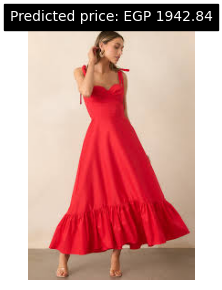

In [4]:
import numpy as np
import requests
from PIL import Image
from io import BytesIO
import tensorflow as tf
import matplotlib.pyplot as plt

# === Preprocessing Function ===
def preprocess_image(url, img_size=(224, 224)):
    try:
        if url.startswith("//"):
            url = "https:" + url  # Fix protocol-relative URLs

        response = requests.get(url, timeout=5)
        response.raise_for_status()
        img = Image.open(BytesIO(response.content)).convert("RGB")
    except Exception as e:
        print(f"Error loading image from {url}: {e}")
        img = Image.new("RGB", img_size, (255, 255, 255))  # Return blank white image on failure

    img = img.resize(img_size)
    img = np.array(img) / 255.0  # Normalize to [0,1]
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# === Prediction Function ===
def predict_price(url):
    img = preprocess_image(url)

    normalized_price = model.predict(img)[0][0]

    # Inverse transform to get original scale
    original_price = normalized_price * (scaler.data_max_[0] - scaler.data_min_[0]) + scaler.data_min_[0]
    return f"Predicted price: EGP {original_price:.2f}"

# === Example Usage ===
def display_image_and_price(url):
    # Predict price using the resized image for the model
    predicted_price = predict_price(url)

    # Reload the original image just for display (at natural size)
    try:
        if url.startswith("//"):
            url = "https:" + url
        response = requests.get(url, timeout=5)
        response.raise_for_status()
        img = Image.open(BytesIO(response.content)).convert("RGB")
    except Exception as e:
        print(f"Error loading image from {url}: {e}")
        img = Image.new("RGB", (224, 224), (255, 255, 255))  # fallback image

    # Set display size small (don't stretch the image)
    fig, ax = plt.subplots(figsize=(3, 3))  # smaller figsize
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(predicted_price, fontsize=10, color='white', backgroundcolor='black')
    plt.tight_layout()
    plt.show()


# Test with a URL
test_url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSRAKQuYT4qokwYUqPjvLk59tO6Bgv2egQ6iA&s"
display_image_and_price(test_url)
